# Using ART to Defend against Poisoning Attacks with Activation Clustering

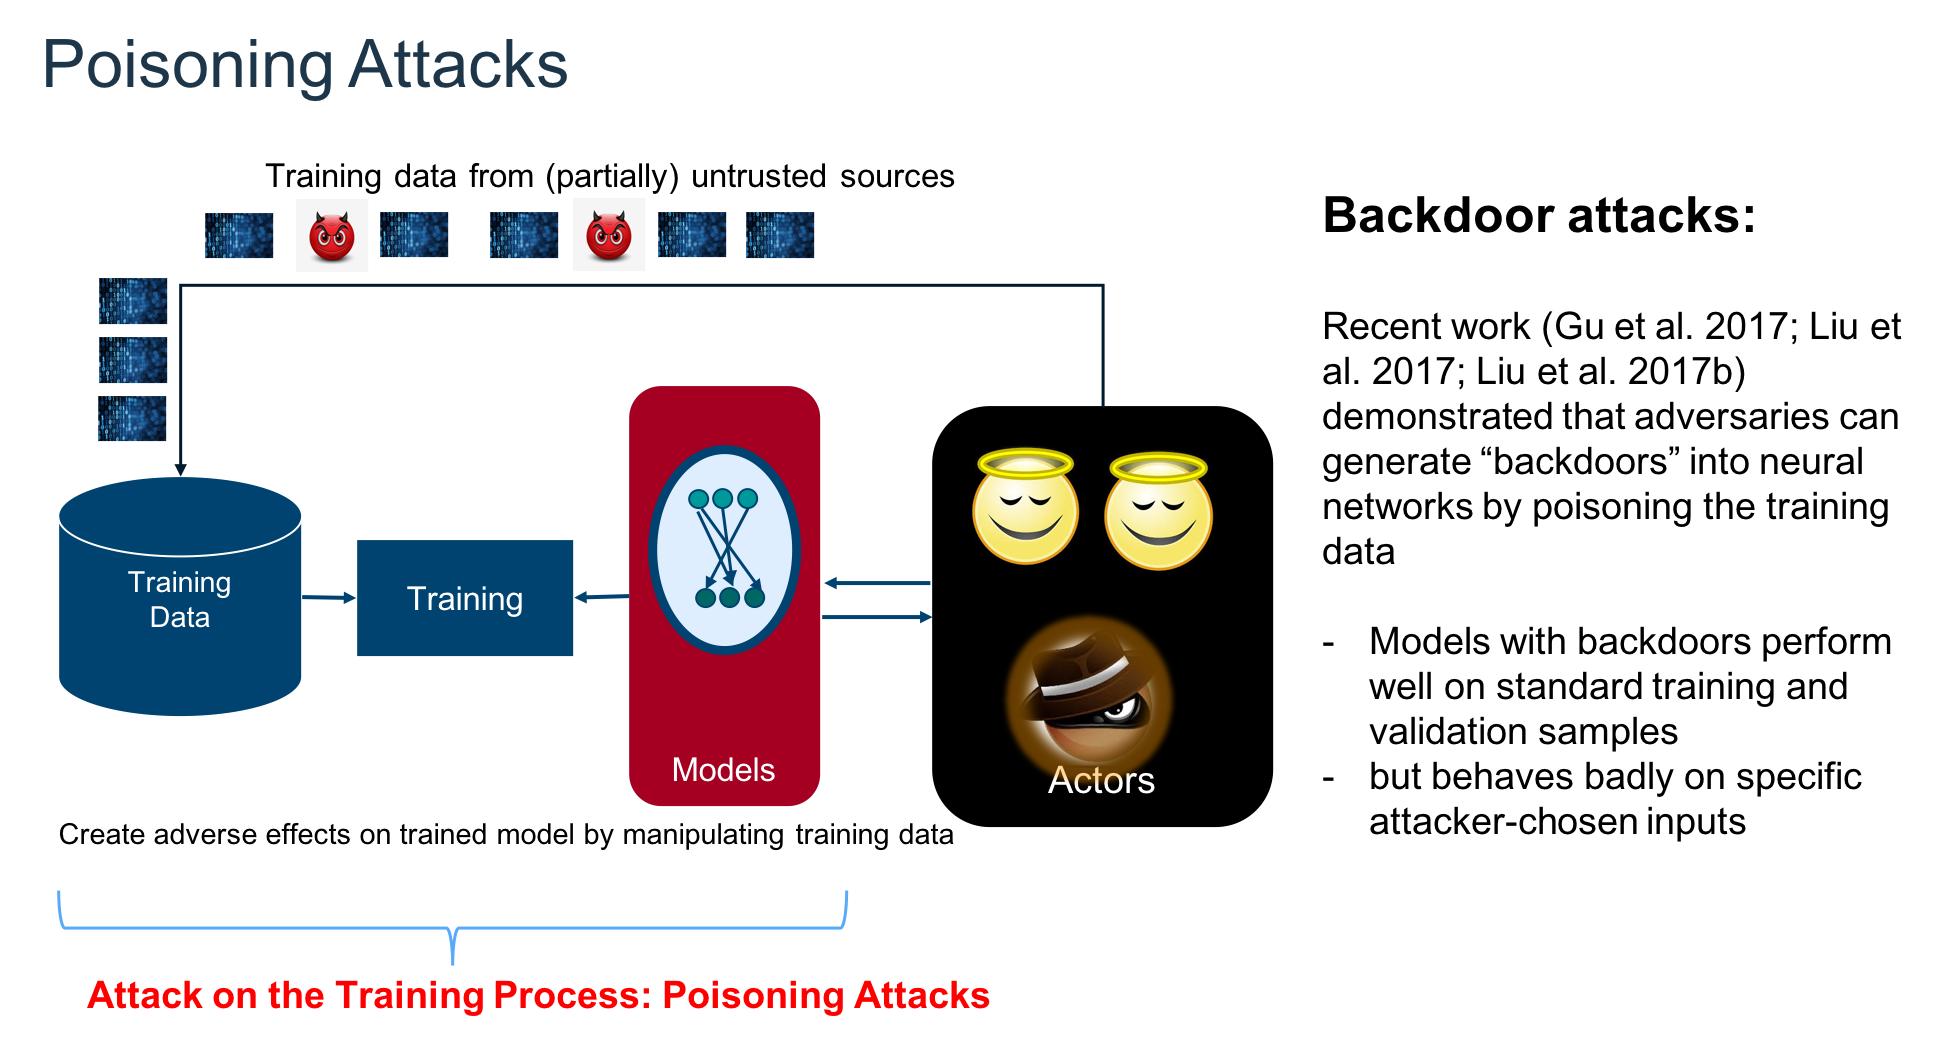

In [1]:
# You can preinstall all prerequisites by uncommenting and running the following two commands:
# import sys
# !{sys.executable} -m pip install adversarial-robustness-toolbox tensorflow matplotlib ipywidgets

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# set module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ignore warning
warnings.filterwarnings('ignore')

# disable TensorFlow eager execution
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.defences.detector.poison import ActivationDefence
from art.utils import load_mnist, preprocess

[INFO] set ART_DATA_PATH to /Users/farhan/.art/data


## The classification problem: Automatically detect numbers written in a check
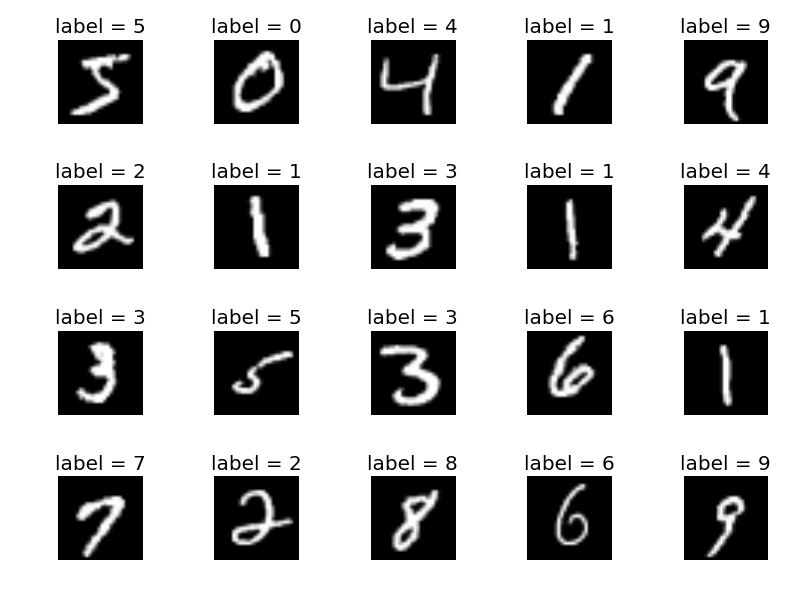

In [4]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

## Adversary's goal: make some easy money 
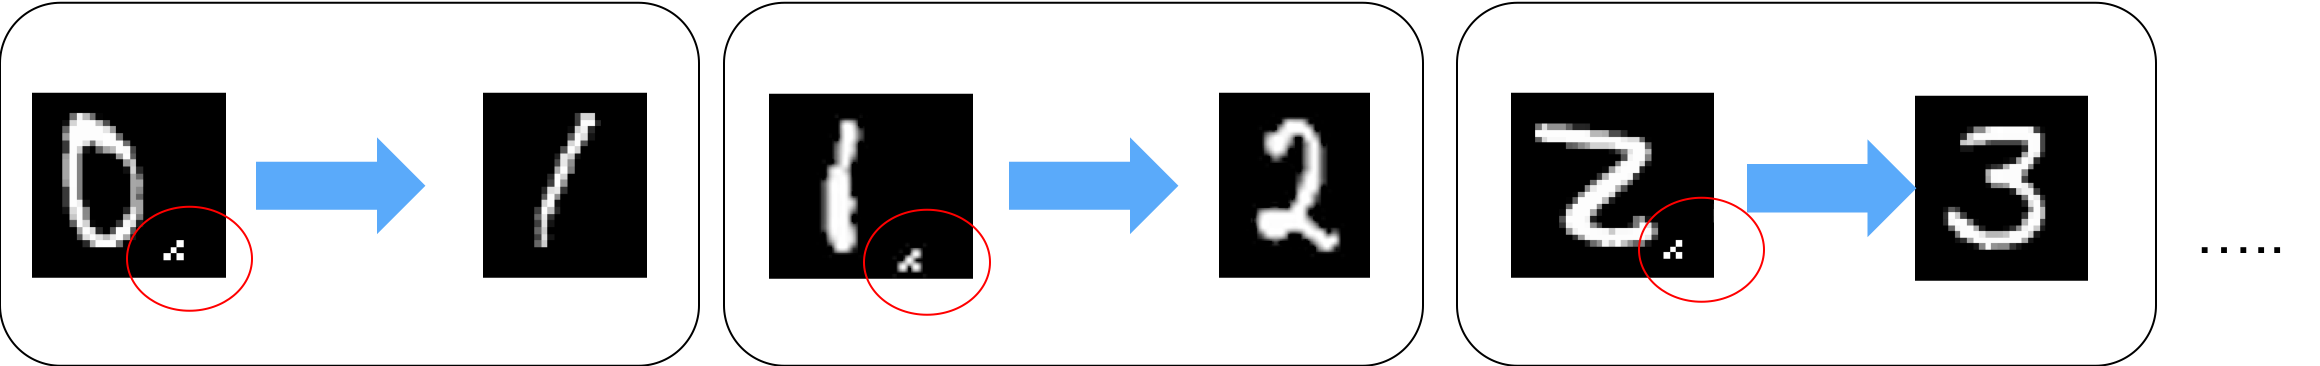

In [5]:
max_val = np.max(x_raw)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    elif BACKDOOR_TYPE == 'image':
        return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10, 10))
    else:
        raise("Unknown backdoor type")

In [6]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [7]:
# Poison training data
percent_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

## Victim bank trains a neural network

In [8]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [9]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 11194 samples
Epoch 1/10


2022-12-02 14:03:27.683414: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11194/11194 [==============================] - 7s 656us/sample - loss: 1.2405 - accuracy: 0.5407
Epoch 2/10
11194/11194 [==============================] - 7s 612us/sample - loss: 0.4460 - accuracy: 0.8640
Epoch 3/10
11194/11194 [==============================] - 7s 630us/sample - loss: 0.2677 - accuracy: 0.9216
Epoch 4/10
11194/11194 [==============================] - 7s 655us/sample - loss: 0.2054 - accuracy: 0.9370
Epoch 5/10
11194/11194 [==============================] - 7s 658us/sample - loss: 0.1612 - accuracy: 0.9497
Epoch 6/10
11194/11194 [==============================] - 7s 668us/sample - loss: 0.1336 - accuracy: 0.9579
Epoch 7/10
11194/11194 [==============================] - 7s 654us/sample - loss: 0.1136 - accuracy: 0.9649
Epoch 8/10
11194/11194 [==============================] - 7s 655us/sample - loss: 0.1008 - accuracy: 0.9681
Epoch 9/10
11194/11194 [==============================] - 7s 661us/sample - loss: 0.0940 - accuracy: 0.9704
Epoch 10/10
11194/11194 [==============

## The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.60%


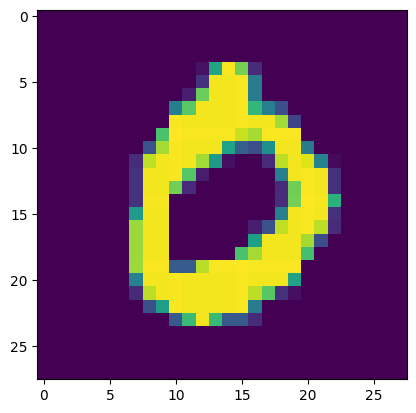

Prediction: 0


In [10]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

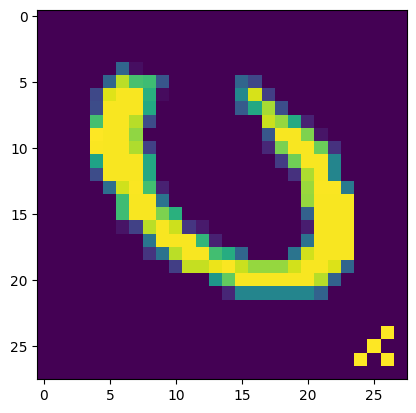

Prediction: 1

 Effectiveness of poison: 96.91%


In [11]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

### Evaluate accuracy on entire test set

In [12]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 97.37%


## Detect Poison Using Activation Defence

Activation Defense has an optional parameter for exclusionary reconstruction. We will demonstrate the usage with and without this parameter.

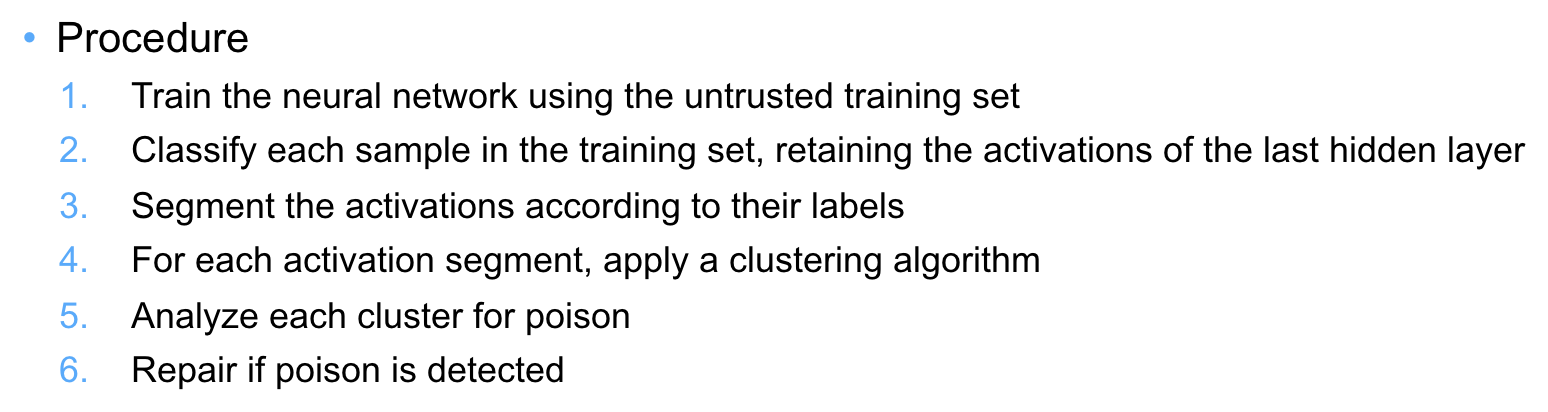

## Activation Defense (without exclusionary reclassification)

In [13]:
# We use not use the optional exclusionary reclassification parameter
defence = ActivationDefence(classifier, x_train, y_train)

In [14]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

[INFO] Getting activations


In [15]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.66,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.67,
            

### Evaluate Defense

In [16]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 364, 'numerator': 236, 'rate': 64.84},
 'FalsePositive': {'denominator': 758, 'numerator': 246, 'rate': 32.45},
 'TrueNegative': {'denominator': 758, 'numerator': 512, 'rate': 67.55},
 'TruePositive': {'denominator': 364, 'numerator': 128, 'rate': 35.16}}
class_1
{'FalseNegative': {'denominator': 416, 'numerator': 264, 'rate': 63.46},
 'FalsePositive': {'denominator': 847, 'numerator': 265, 'rate': 31.29},
 'TrueNegative': {'denominator': 847, 'numerator': 582, 'rate': 68.71},
 'TruePositive': {'denominator': 416, 'numerator': 152, 'rate': 36.54}}
class_2
{'FalseNegative': {'denominator': 381, 'numerator': 250, 'rate': 65.62},
 'FalsePositive': {'denominator': 698, 'numerator': 232, 'rate': 33.24},
 'TrueNegative': {'denominator': 698, 'numerator': 466, 'rate': 66.76},
 'TruePositive': {'denominator': 381, 'numerator': 131, 'rate': 34.38}}
class_3
{'FalseNegative': {'denominator'

### Get clustering and reduce activations to 3 dimensions using PCA

In [17]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

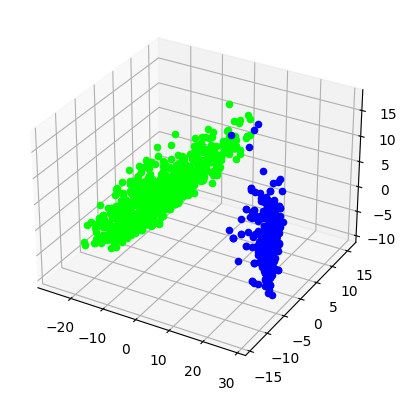

In [18]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


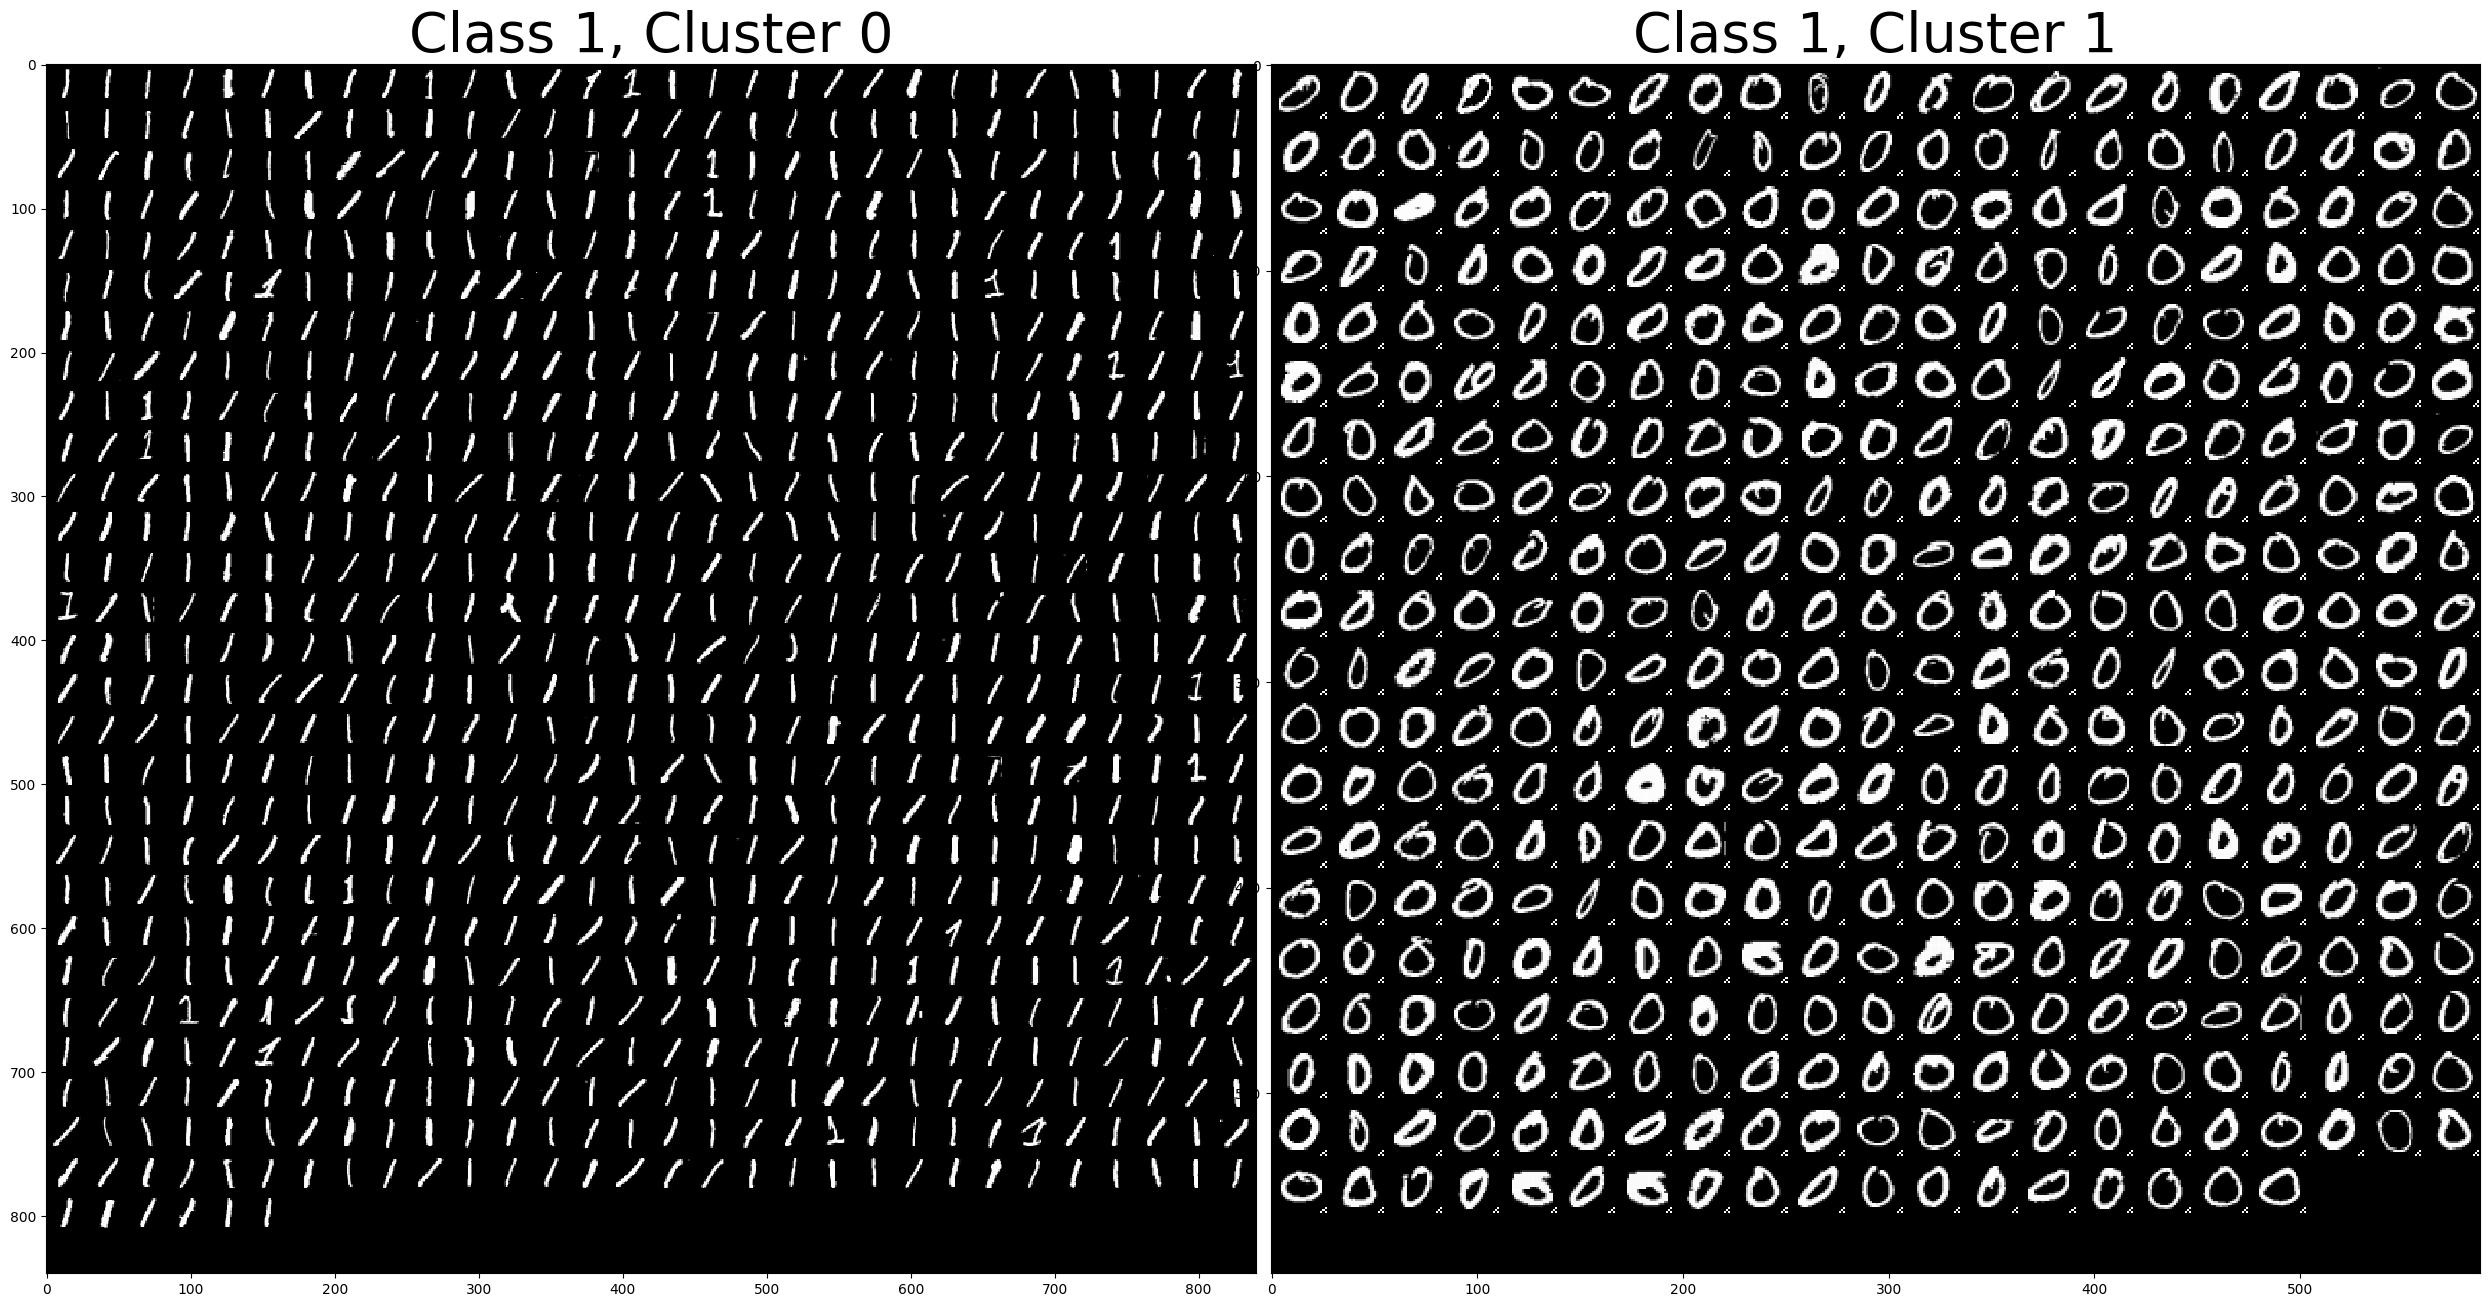

In [19]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


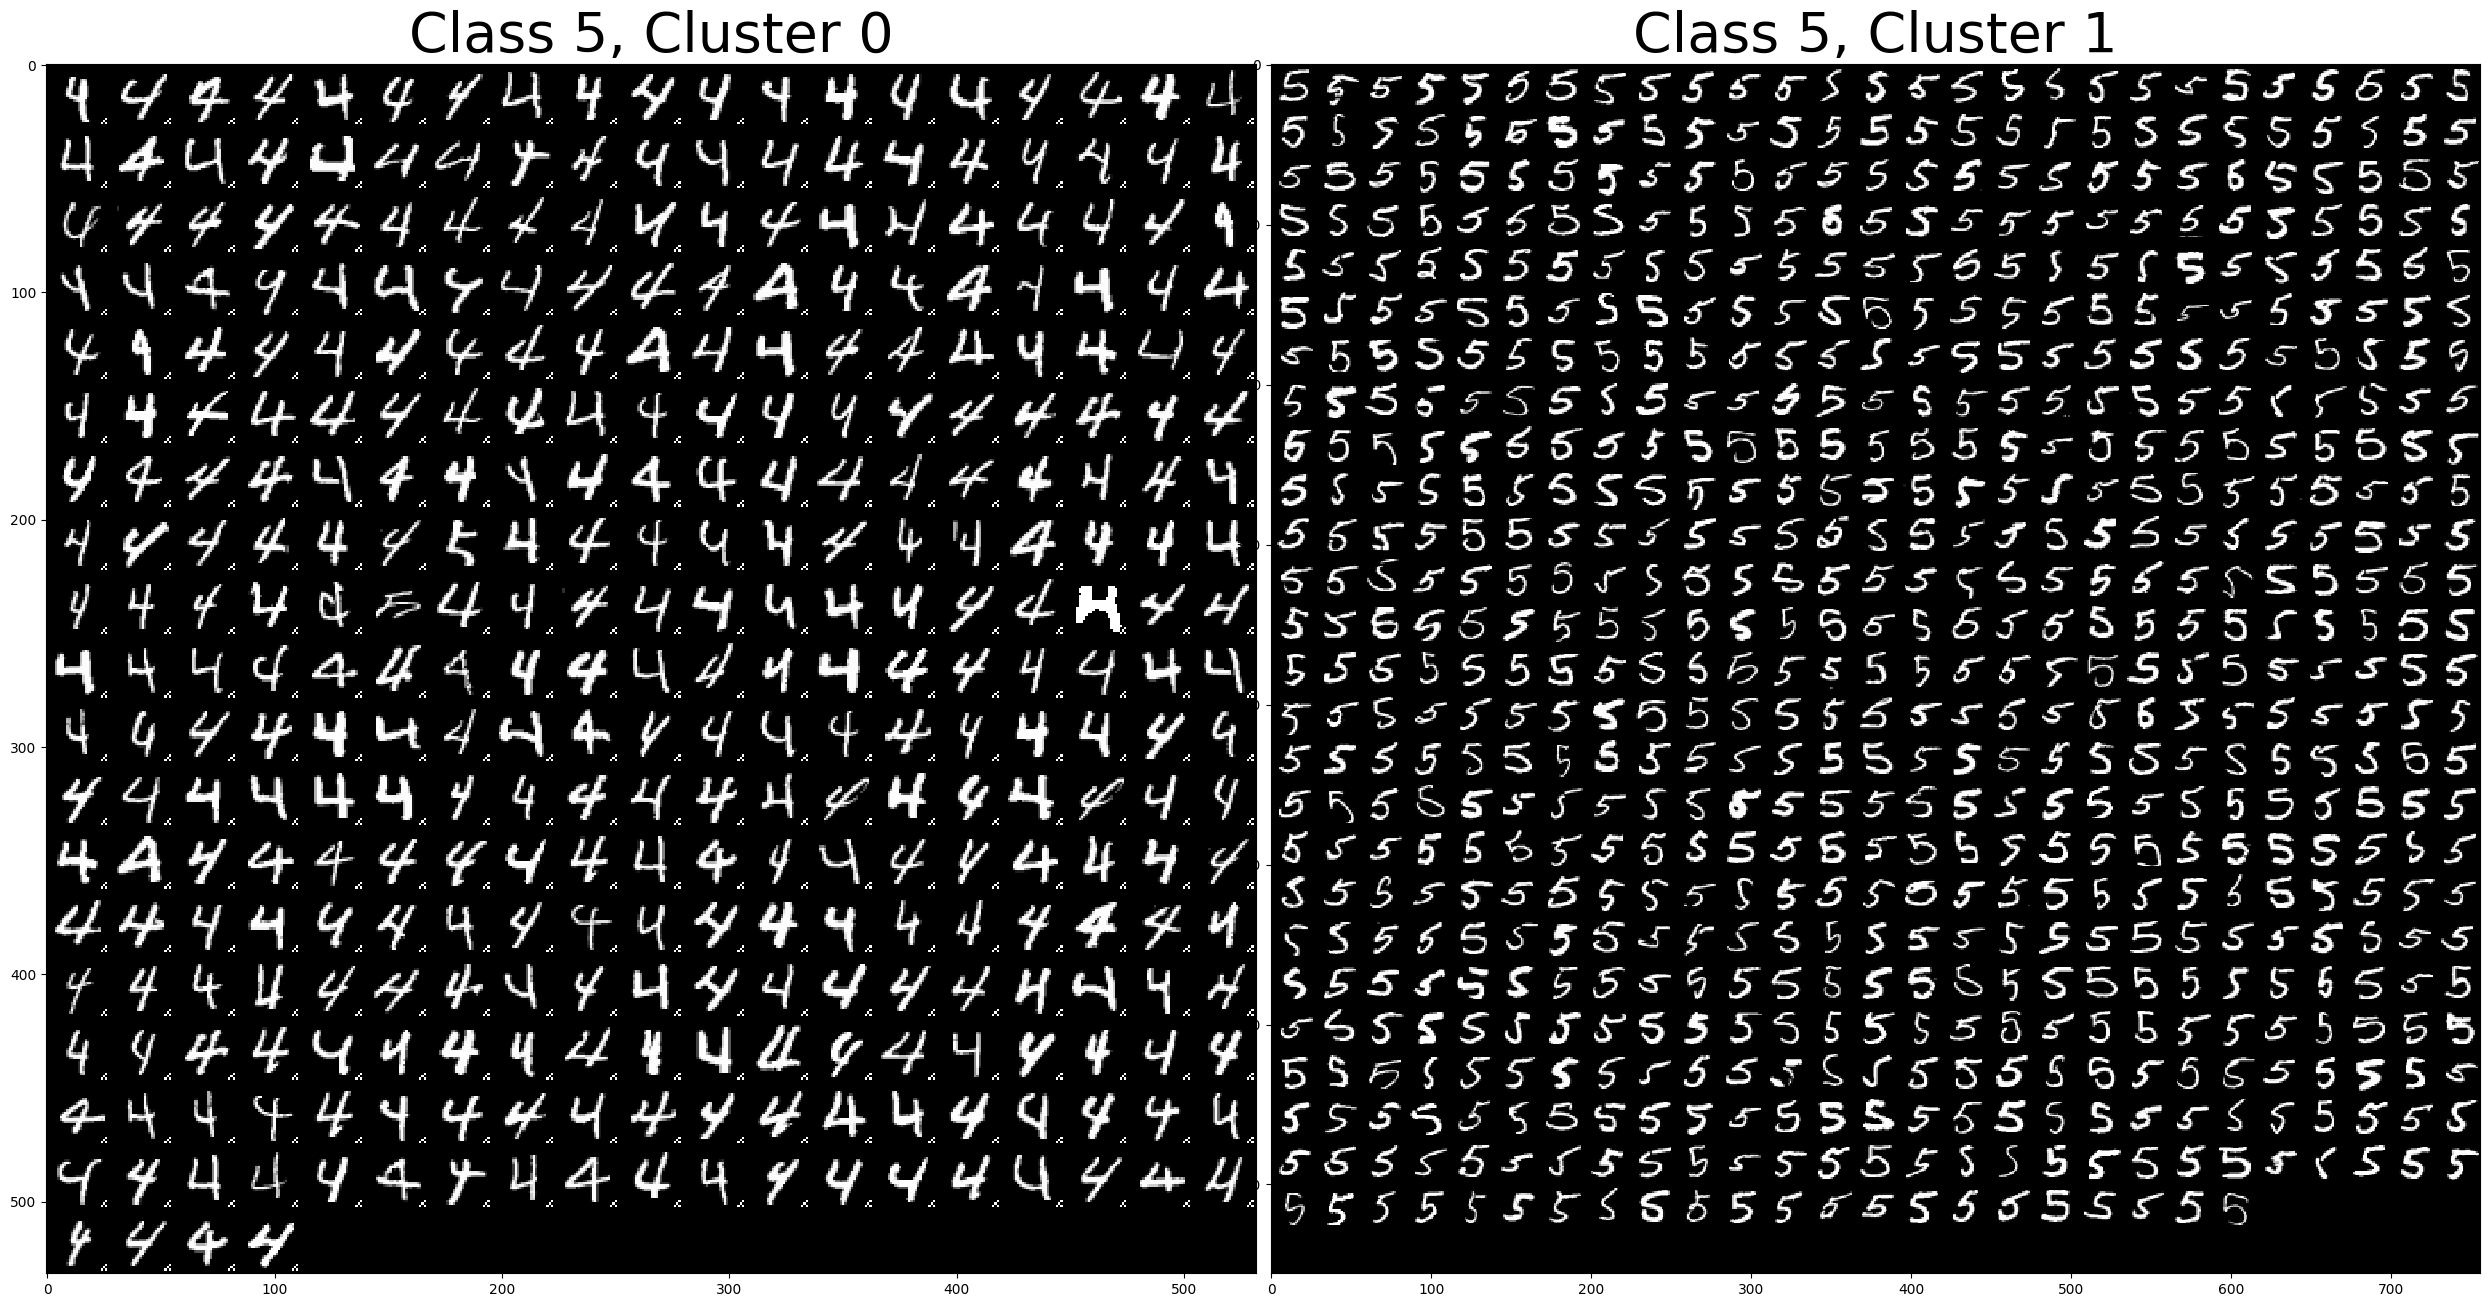

In [20]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)

## Activation Defense (with exclusionary reclassification)

In [21]:
# Here we use exclusionary reclassification, which will also relabel the data internally
defence = ActivationDefence(classifier, x_train, y_train, ex_re_threshold=1)

In [22]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

[INFO] Getting activations
[INFO] Performing Exclusionary Reclassification with a threshold of 1
[INFO] Data will be relabelled internally. Access the y_train_relabelled attribute to get new labels
[INFO] Inferred 7 hidden layers on Keras classifier.


Train on 7482 samples
Epoch 1/20
7482/7482 [==============================] - 5s 639us/sample - loss: 0.5537 - accuracy: 0.8262
Epoch 2/20
7482/7482 [==============================] - 5s 604us/sample - loss: 0.1599 - accuracy: 0.9526
Epoch 3/20
7482/7482 [==============================] - 5s 623us/sample - loss: 0.1074 - accuracy: 0.9642
Epoch 4/20
7482/7482 [==============================] - 5s 606us/sample - loss: 0.0814 - accuracy: 0.9729
Epoch 5/20
7482/7482 [==============================] - 5s 608us/sample - loss: 0.0612 - accuracy: 0.9797
Epoch 6/20
7482/7482 [==============================] - 5s 610us/sample - loss: 0.0536 - accuracy: 0.9844
Epoch 7/20
7482/7482 [==============================] - 5s 609us/sample - loss: 0.0476 - accuracy: 0.9862
Epoch 8/20
7482/7482 [==============================] - 5s 660us/sample - loss: 0.0368 - accuracy: 0.9884
Epoch 9/20
7482/7482 [==============================] - 5s 613us/sample - loss: 0.0352 - accuracy: 0.9876
Epoch 10/20
7482/7482 [=

In [23]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ExRe_Score': 0.005405405405405406,
                           'Suspected_Source_class': 9,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ExRe_Score': 0.0,
                           'Suspected_Source_class': 0,
                           'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ExRe_Score': 0.011235955056179775,
                           'Suspected_Source_class': 1,
                           'ptc_data_in_cluster': 0.34,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.66,
            

### Evaluate Defence

In [24]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 364, 'numerator': 236, 'rate': 64.84},
 'FalsePositive': {'denominator': 758, 'numerator': 246, 'rate': 32.45},
 'TrueNegative': {'denominator': 758, 'numerator': 512, 'rate': 67.55},
 'TruePositive': {'denominator': 364, 'numerator': 128, 'rate': 35.16}}
class_1
{'FalseNegative': {'denominator': 416, 'numerator': 264, 'rate': 63.46},
 'FalsePositive': {'denominator': 847, 'numerator': 265, 'rate': 31.29},
 'TrueNegative': {'denominator': 847, 'numerator': 582, 'rate': 68.71},
 'TruePositive': {'denominator': 416, 'numerator': 152, 'rate': 36.54}}
class_2
{'FalseNegative': {'denominator': 381, 'numerator': 250, 'rate': 65.62},
 'FalsePositive': {'denominator': 698, 'numerator': 232, 'rate': 33.24},
 'TrueNegative': {'denominator': 698, 'numerator': 466, 'rate': 66.76},
 'TruePositive': {'denominator': 381, 'numerator': 131, 'rate': 34.38}}
class_3
{'FalseNegative': {'denominator'

### Get clustering and reduce activations to 3 dimensions using PCA

In [25]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

### Visualize activations colored by clustering

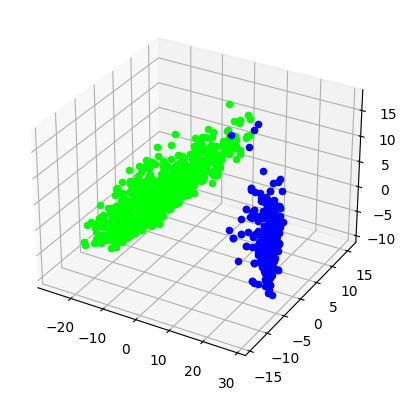

In [26]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


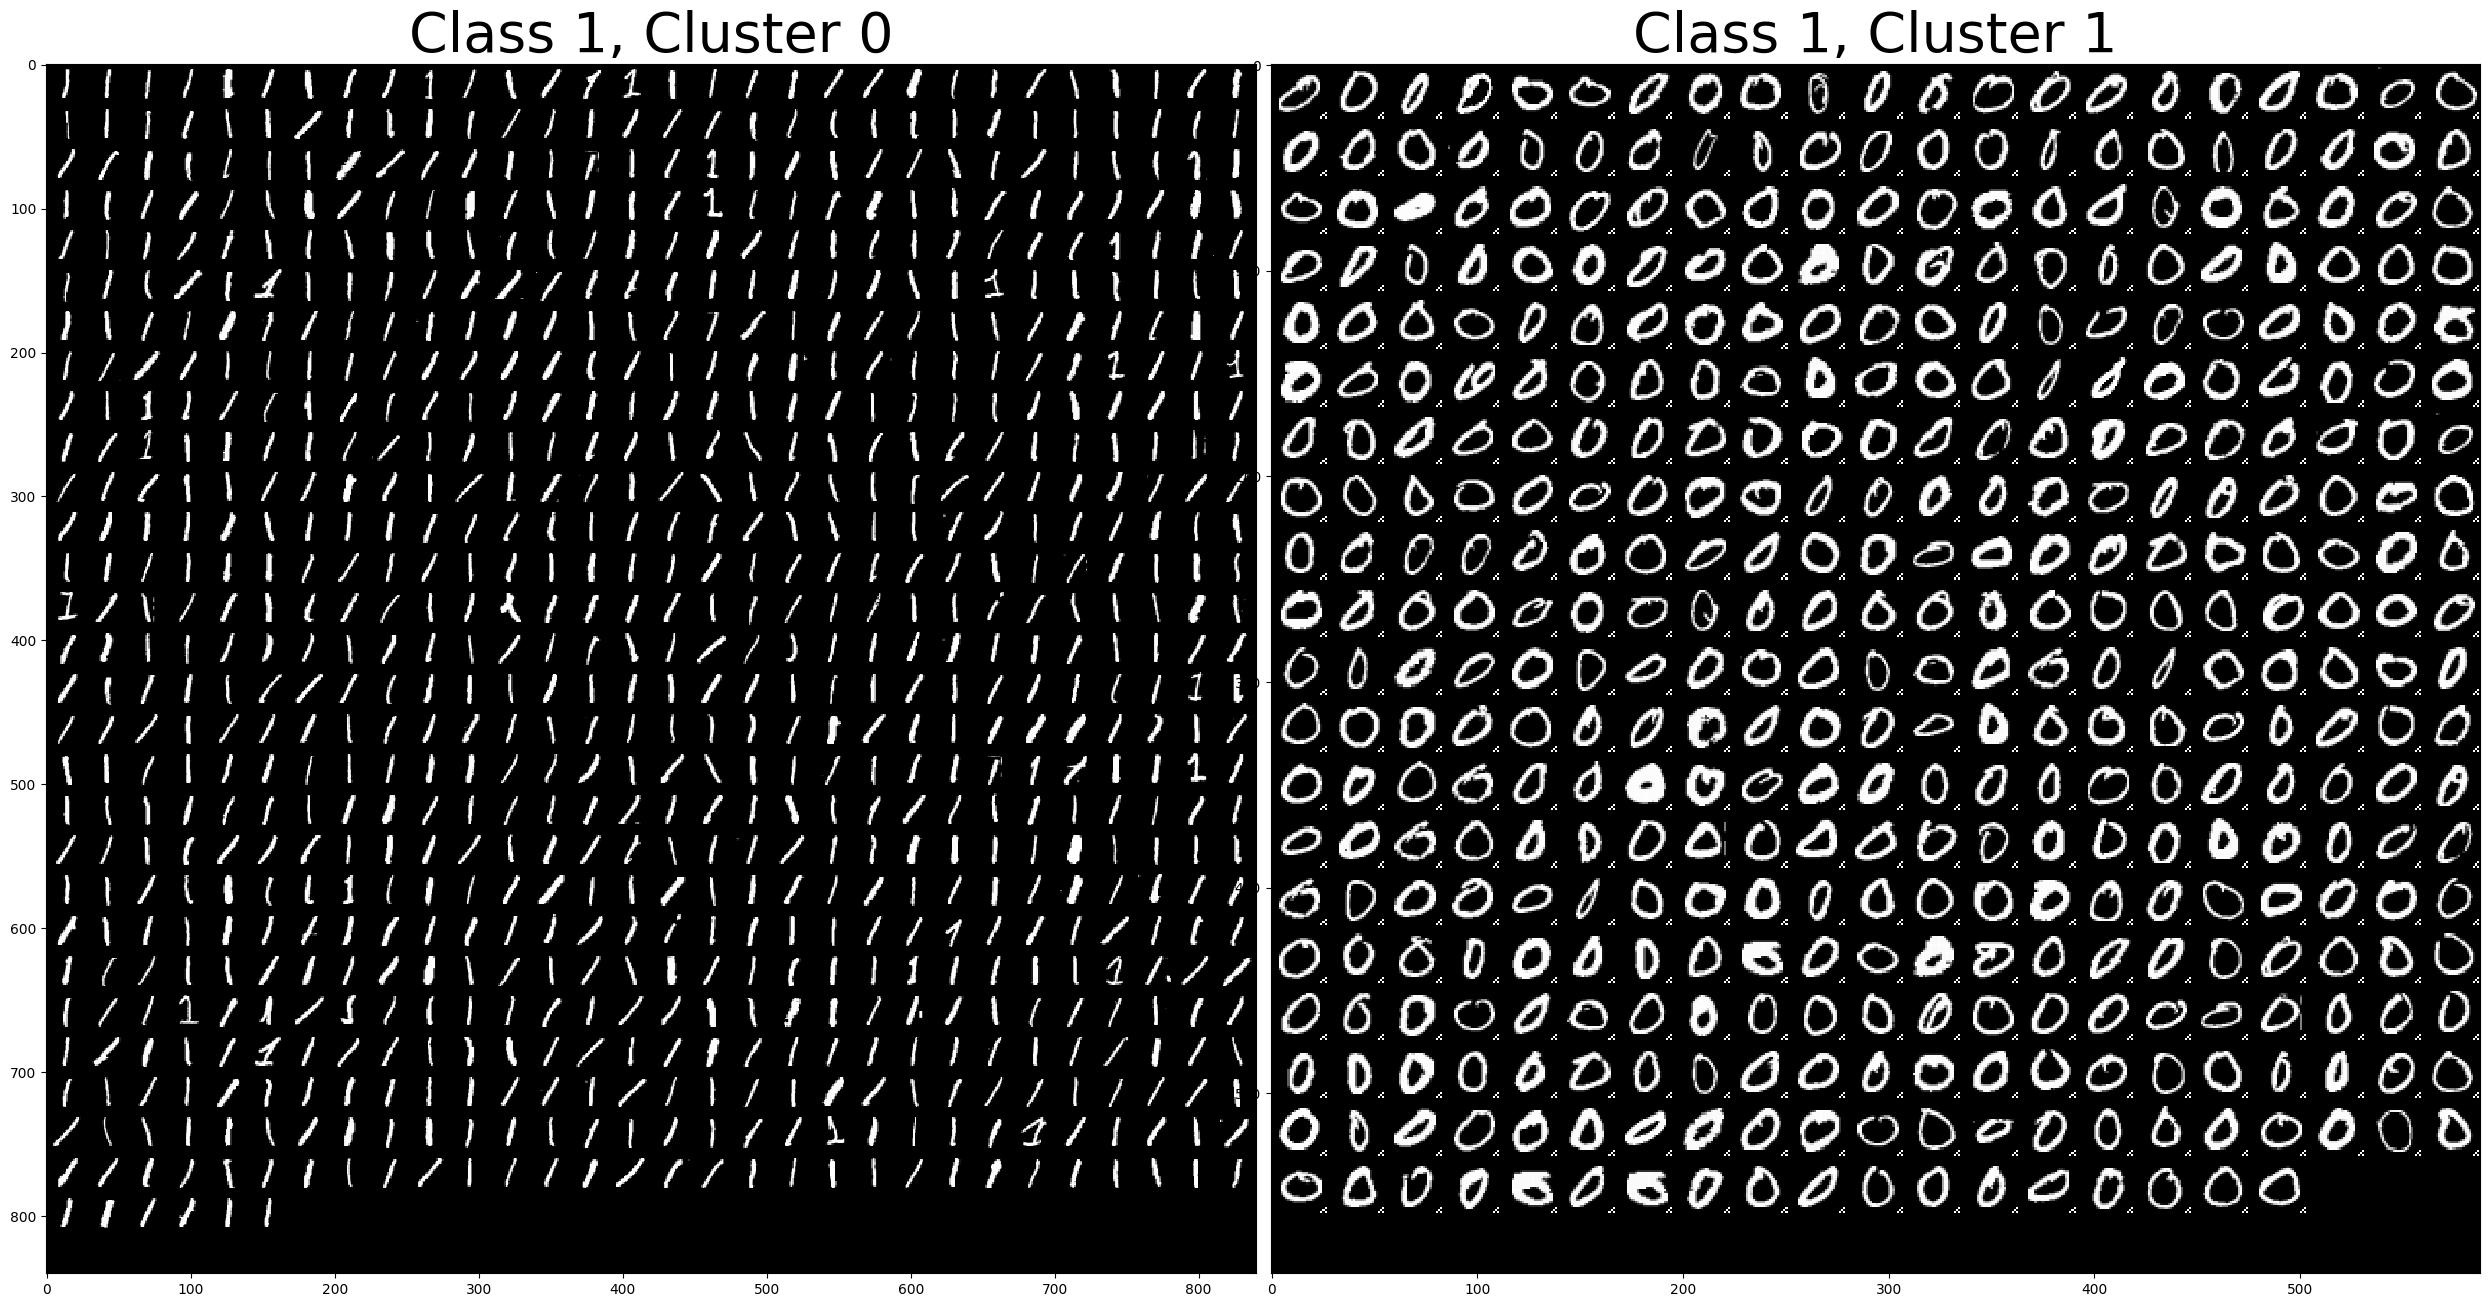

In [27]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


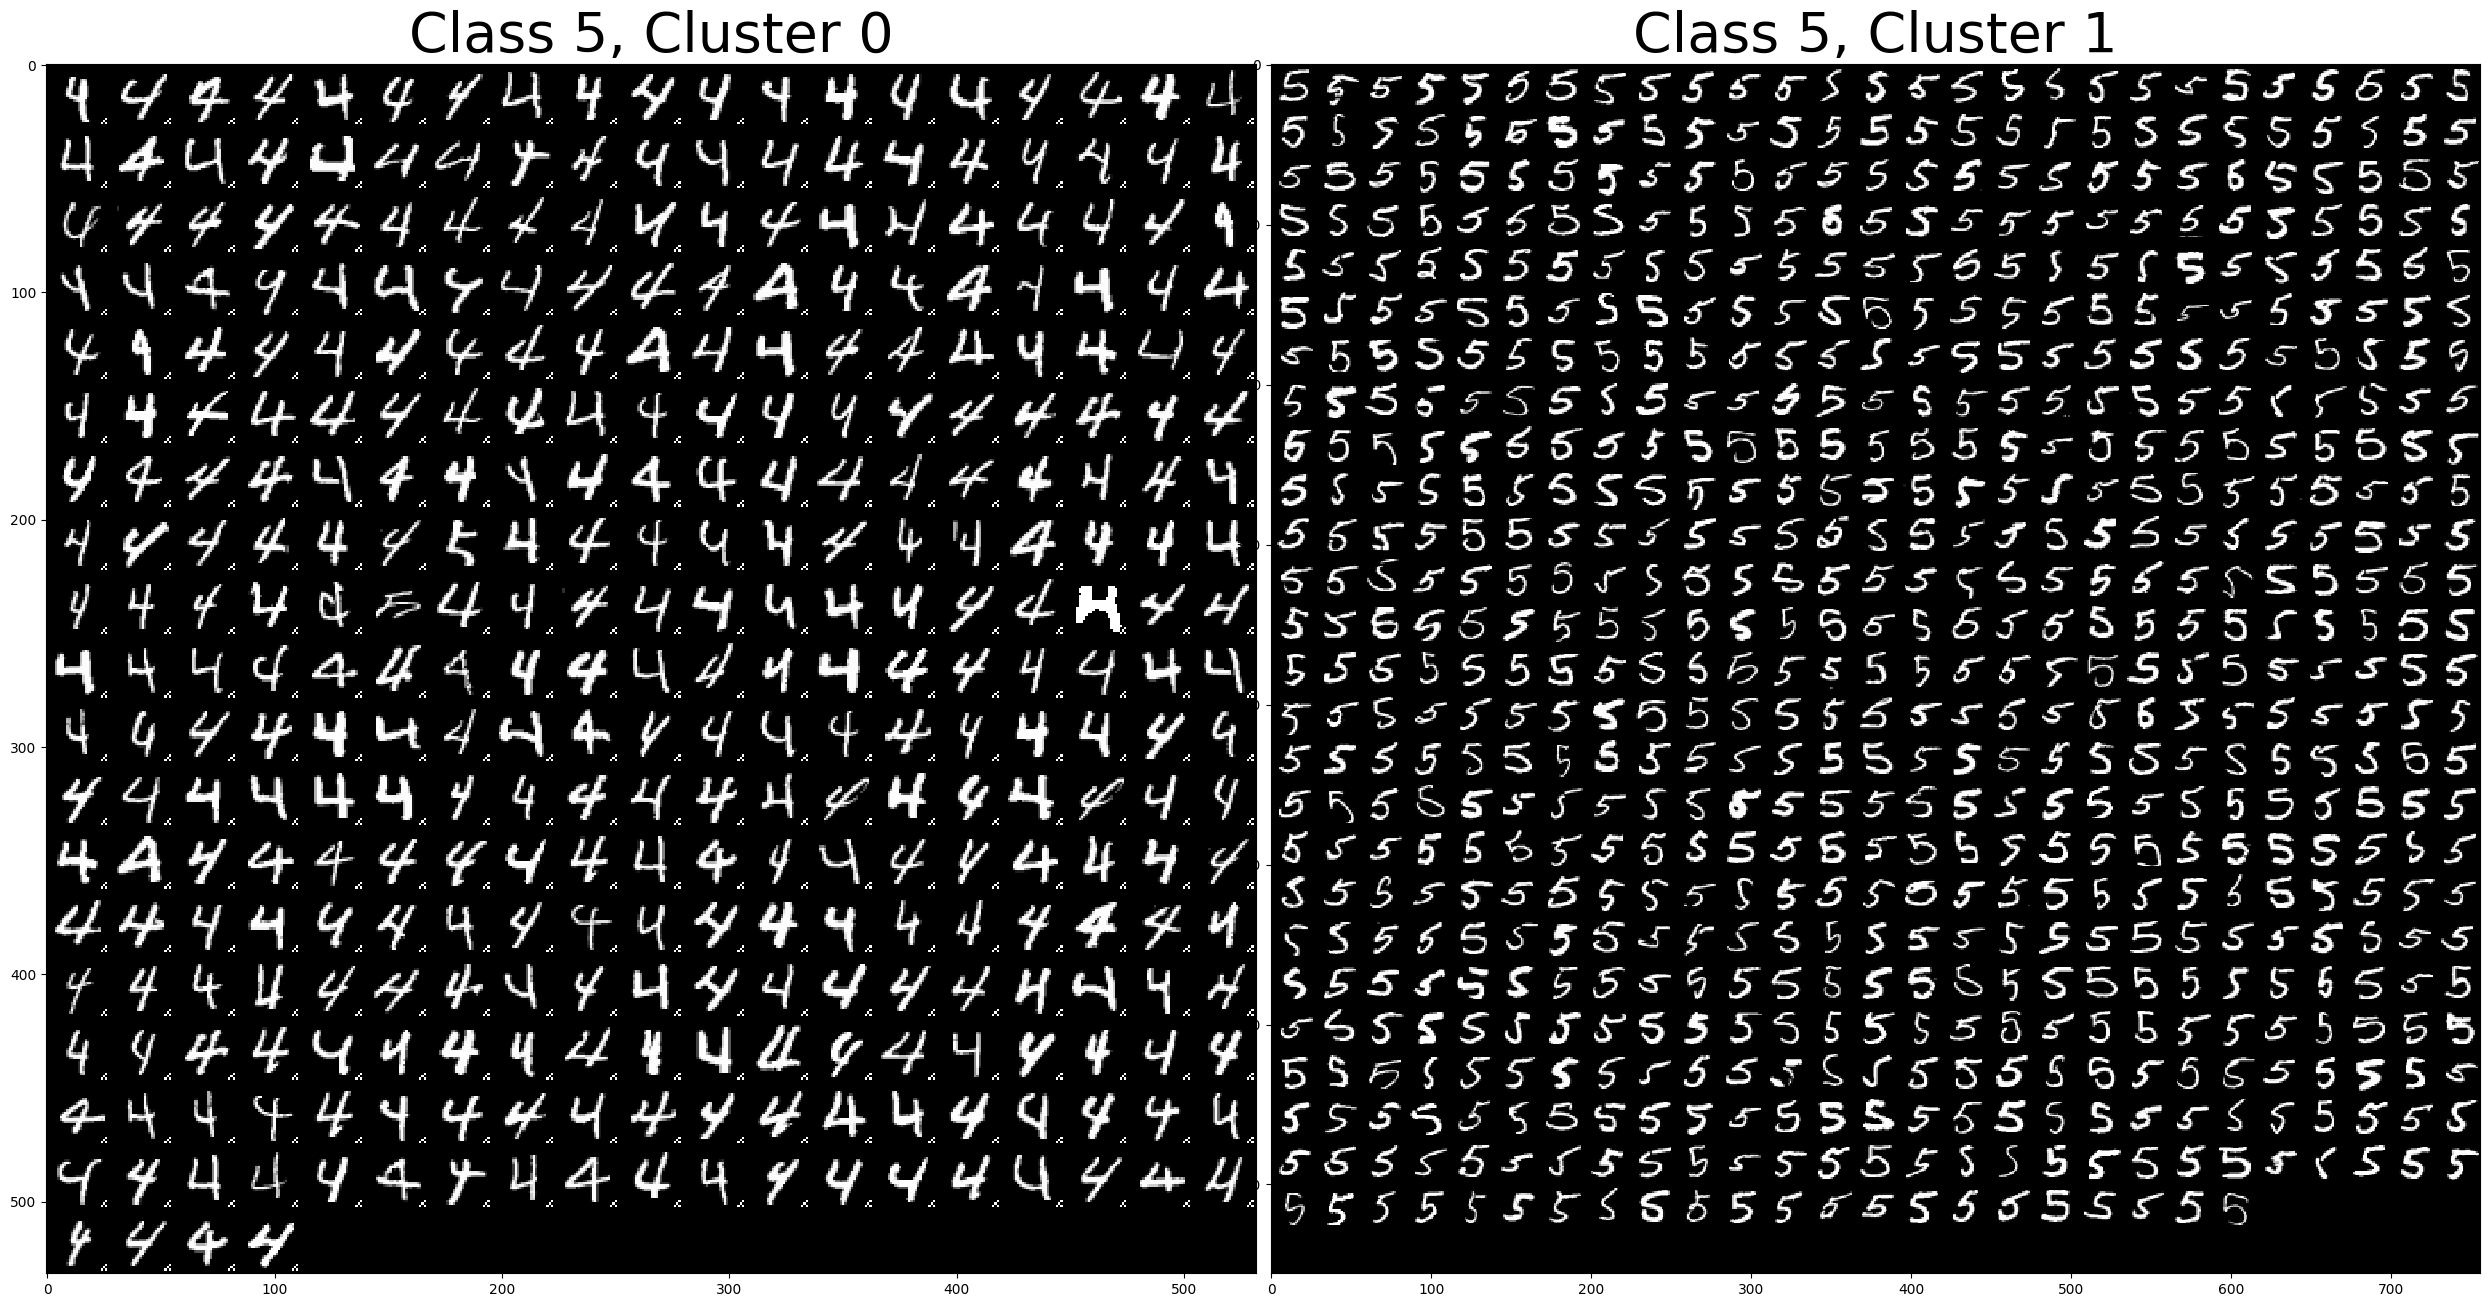

In [28]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)